`ECML2024 Tutorial / An Introduction to Machine Learning from Time Series`

# Deep learning based Time Series Machine Learning in `aeon`

Deep learning has been demonstrated to be highly effective across various time series tasks, including classification, extrinsic regression, and clustering. In particular, convolution-based architectures such as FCN and ResNet have shown impressive performance for Time Series Classification (TSC) tasks, as highlighted by extensive experiments in [[1]](#references) and [[2]](#references). Following these developments, InceptionTime, a convolution-based architecture, emerged as the new state-of-the-art model for TSC [[3]](#references). Enhancements were later introduced with hand-crafted convolution filters in Hybrid InceptionTime (H-InceptionTime), which became the current state-of-the-art model in TSC as noted in [[4]](#references) and [[5]](#references).

Recent reviews on Time Series Extrinsic Regression (TSER) have also affirmed that InceptionTime remains the leading deep learning model for regression tasks [[6]](#references). Additionally, the potential of deep learning models in time series clustering is gaining attention due to their ability to capture complex temporal patterns.

While research in TSCL is still emerging compared to classification and regression, early results indicate that convolution-based models like ResNet, originally developed for TSC, can also deliver substantial improvements in clustering tasks [[7]](#references).

In this notebook, we cover the usage of the deep learning models for both TSC and TSER on EEG applications.

For all figures used in this demo, we use the one provided by the [Deep Learning for Time Series Classification webpage](https://msd-irimas.github.io/pages/dl4tsc/) with this reference figure for all legends needed:

__Note:__  All deep learners in `aeon` currently are based on `tensorflow`. You will need to `pip install tensorflow` to run this code.

<img src="./img/deep-legend.png" alt="Deep Legend."><i>

## Table of Contents <a id='toc'></a>

* [Load example data](#load-data)
* [Simple Multiple Linear Perceptron (MLP)](#mlp)
    * [Using MLP for Classification and Regression](#mlp-usage)
* [Time Convolutional Neural Network (TimeCNN)](#time-cnn-network)
    * [Using TimeCNN for Classification and Regression](#time-cnn-usage)
* [Inception Based Networks](#inception-models)
    * [InceptionTime](#inceptiontime)
        * [Using InceptionTime for Classification and Regression](#inceptiontime-usage)
    * [Hybrid InceptionTime](#hinceptiontime)
        * [Using Hybrid InceptionTime for Classification and Regression](#hinceptiontime-usage)
    * [LITETime](#litetime)
        * [Using LITETime for Classification and Regression](#litetime-usage)
* [Performance on the UCR univariate classification datasets](#evaluation)
* [Deep Learning for Time Series Clustering](#clustering)
    * [Auto-Encoder Fully Convolutional Network (AEFCN) for Clustering](#aefcn)
    * [Auto-Encoder ResNet (AEResNet) for Clustering](#aeresnet)
* [References](#references)

In [ ]:
!pip install aeon==0.11.0 tensorflow

In [1]:
# There are some deprecation warnings present in the notebook, we will ignore them.
# Remove this cell if you are interested in finding out what is changing soon, for
# aeon there will be big changes in out v1.0.0 release!
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
from aeon.registry import all_estimators

all_estimators(
    "classifier", filter_tags={"algorithm_type": "deeplearning"}, as_dataframe=True
)

2024-09-06 15:13:31.175352: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-06 15:13:31.176213: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-06 15:13:31.216175: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-06 15:13:31.439081: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-06 15:13:32.021312: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warnin

,name,estimator
0,CNNClassifier,<class 'aeon.classification.deep_learning._cnn...
1,EncoderClassifier,<class 'aeon.classification.deep_learning._enc...
2,FCNClassifier,<class 'aeon.classification.deep_learning._fcn...
3,InceptionTimeClassifier,<class 'aeon.classification.deep_learning._inc...
4,IndividualInceptionClassifier,<class 'aeon.classification.deep_learning._inc...
5,IndividualLITEClassifier,<class 'aeon.classification.deep_learning._lit...
6,LITETimeClassifier,<class 'aeon.classification.deep_learning._lit...
7,MLPClassifier,<class 'aeon.classification.deep_learning._mlp...
8,ResNetClassifier,<class 'aeon.classification.deep_learning._res...
9,TapNetClassifier,<class 'aeon.classification.deep_learning._tap...


In [3]:
all_estimators(
    "regressor", filter_tags={"algorithm_type": "deeplearning"}, as_dataframe=True
)

,name,estimator
0,CNNRegressor,<class 'aeon.regression.deep_learning._cnn.CNN...
1,EncoderRegressor,<class 'aeon.regression.deep_learning._encoder...
2,FCNRegressor,<class 'aeon.regression.deep_learning._fcn.FCN...
3,InceptionTimeRegressor,<class 'aeon.regression.deep_learning._incepti...
4,IndividualInceptionRegressor,<class 'aeon.regression.deep_learning._incepti...
5,IndividualLITERegressor,<class 'aeon.regression.deep_learning._lite_ti...
6,LITETimeRegressor,<class 'aeon.regression.deep_learning._lite_ti...
7,MLPRegressor,<class 'aeon.regression.deep_learning._mlp.MLP...
8,ResNetRegressor,<class 'aeon.regression.deep_learning._resnet....
9,TapNetRegressor,<class 'aeon.regression.deep_learning._tapnet....


In [4]:
all_estimators(
    "clusterer", filter_tags={"algorithm_type": "deeplearning"}, as_dataframe=True
)

,name,estimator
0,AEFCNClusterer,<class 'aeon.clustering.deep_learning._ae_fcn....
1,AEResNetClusterer,<class 'aeon.clustering.deep_learning._ae_resn...


## Load example data <a id='load-data'></a>

### ECG Classification <a id="eeg-classification-data"></a>

In [7]:
from aeon.datasets import load_classification

X_train_c, y_train_c = load_classification("ECG200", split="train")
X_test_c, y_test_c = load_classification("ECG200", split="test")

# znormalize the series
X_train_c = (X_train_c - X_train_c.mean(axis=-1, keepdims=True)) / (X_train_c.std(axis=-1, keepdims=True))
X_test_c = (X_test_c - X_test_c.mean(axis=-1, keepdims=True)) / (X_test_c.std(axis=-1, keepdims=True))

print("Train shape:", X_train_c.shape)
print("Test shape:", X_test_c.shape)

Train shape: (100, 1, 96)
Test shape: (100, 1, 96)


(<Figure size 1200x600 with 2 Axes>, array([<Axes: >, <Axes: >], dtype=object))

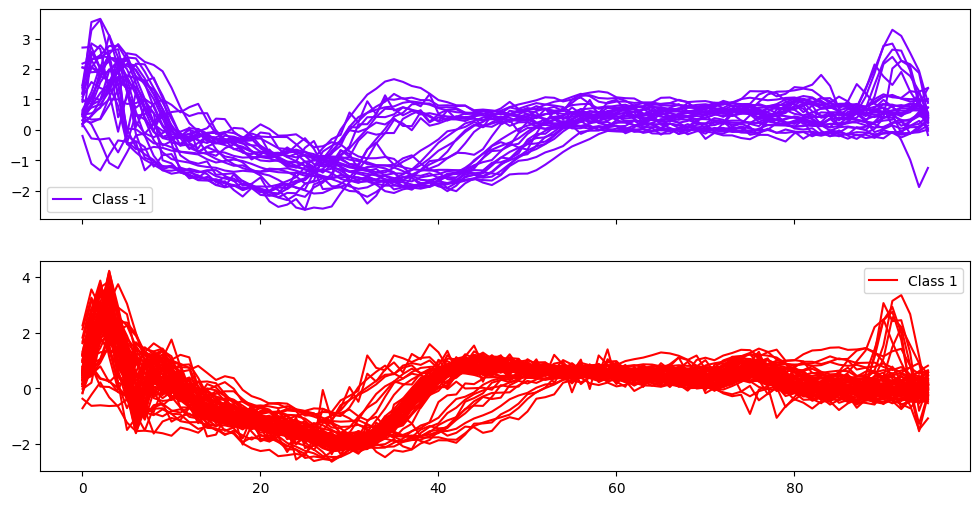

In [8]:
from aeon.visualisation import plot_collection_by_class

plot_collection_by_class(X_train_c[:,0,:], y_train_c)

### Covid Death Rate Regression <a id="eeg-regression-data"></a>

In [38]:
from aeon.datasets import load_regression
import numpy as np

X_train_r, y_train_r = load_regression("Covid3Month", split="train")
X_test_r, y_test_r = load_regression("Covid3Month", split="test")

# znormalize the series

stds_train = (X_train_r.std(axis=-1, keepdims=True))
stds_train[stds_train == 0.0] = 1.0
X_train_r = (X_train_r - X_train_r.mean(axis=-1, keepdims=True)) / stds_train

stds_test = (X_test_r.std(axis=-1, keepdims=True))
stds_test[stds_test == 0.0] = 1.0
X_test_r = (X_test_r - X_test_r.mean(axis=-1, keepdims=True)) / stds_test

print("Train shape:", X_train_r.shape)
print("Test shape:", X_test_r.shape)

Train shape: (140, 1, 84)
Test shape: (61, 1, 84)


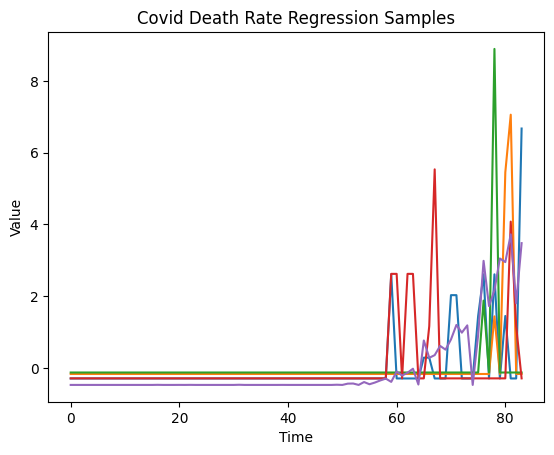

In [40]:
from matplotlib import pyplot as plt

plt.plot(X_train_r[:5,0,:].T)
plt.title("Covid Death Rate Regression Samples")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

# Simple Multi Layer Perceptron (MLP) <a id='mlp'></a>

The Multilayer Perceptron (MLP) [[2]](#references), the simplest model in neural networks, is often used as a baseline for deep learning models. However, when applied to time series data, it fails to account for temporal dependencies. The MLP model tries to find the optimal non-linear combination of input features to achieve a good performance of a downstream task.

<img src="./img/MLP.png" alt="mlp"><i>

## Using MLP for Classification and Regression <a id='mlp-usage'></a>

In [24]:
from aeon.classification.deep_learning import MLPClassifier
from sklearn.metrics import accuracy_score

mlp_cls = MLPClassifier(n_epochs=100)
mlp_cls.fit(X_train_c, y_train_c)
mlp_cls_preds = mlp_cls.predict(X_test_c)
print(accuracy_score(y_test_c, mlp_cls_preds))

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
0.69


In [41]:
from aeon.regression.deep_learning import MLPRegressor
from sklearn.metrics import mean_squared_error

mlp_rgs = MLPRegressor(n_epochs=100)
mlp_rgs.fit(X_train_r, y_train_r)
mlp_rgs_preds = mlp_rgs.predict(X_test_r)
print(mean_squared_error(y_test_r, mlp_rgs_preds))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
0.02518353139930945


(<Figure size 600x600 with 1 Axes>,
 <Axes: title={'center': 'MLP Predictions'}, xlabel='Actual values', ylabel='Predicted values'>)

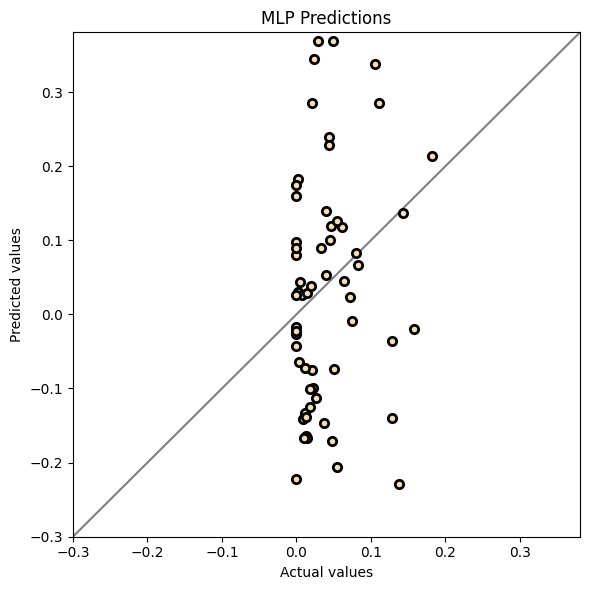

In [42]:
from aeon.visualisation import plot_scatter_predictions

plot_scatter_predictions(y_test_r, mlp_rgs_preds, title="MLP Predictions")

## The Time Convolutional Neural Network (TimeCNN) <a id="time-cnn-network"></a>

The Time Convolutional Neural Network (TimeCNN) [[8]](#references) is a convolutional neural network where the optimization process focuses on learning the most effective filters to achieve optimal results. Unlike MLP, TimeCNN leverages local convolutions, allowing them to capture and consider temporal dependencies in the data, making them more suitable for time series analysis.

<img src="./img/TimeCNN.png" alt="cnn"><i>

## Using TimeCNN for Classification and Regression <a id='time-cnn-usage'></a>

In [29]:
from aeon.classification.deep_learning import CNNClassifier
from sklearn.metrics import accuracy_score

# n_epochs chooses the number of training iterations
# verbose show the network's detail and the logs of training
cnn_cls = CNNClassifier(n_epochs=500, verbose=True, save_best_model=True, best_file_name="best_cnn")
cnn_cls.fit(X_train_c, y_train_c)
cnn_cls_preds = cnn_cls.predict(X_test_c)
print(accuracy_score(y_test_c, cnn_cls_preds))

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 96, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 90, 6)          │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d               │ (None, 30, 6)          │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 24, 12)         │           516 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_1             │ (None, 8, 12)          │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 2)              │           194 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 758 (2.96 KB)

 Trainable params: 758 (2.96 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3754 - loss: 0.2757  
Epoch 2/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6029 - loss: 0.2460 
Epoch 3/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6246 - loss: 0.2346 
Epoch 4/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6246 - loss: 0.2347 
Epoch 5/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6246 - loss: 0.2388 
Epoch 6/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6246 - loss: 0.2428 
Epoch 7/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6246 - loss: 0.2452 
Epoch 8/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6246 - loss: 0.2461 
Epoch 9/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6246 - loss: 0.2459 
Epoch 10/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6246 - loss: 0.2453 
Epoch 11/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6246 - loss: 0.2444 
Epoch 12/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6246 - lo

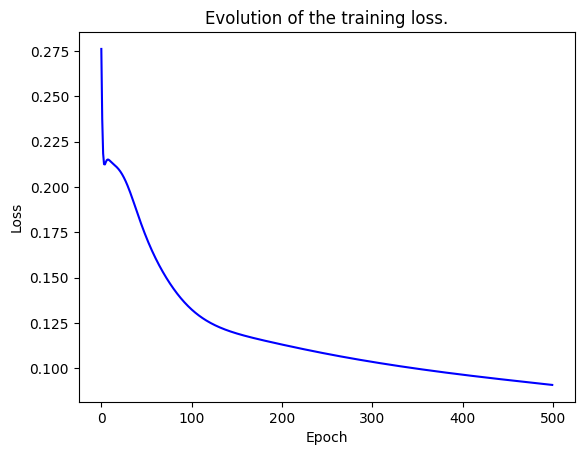

In [30]:
import matplotlib.pyplot as plt

# you can retrieve the history of training to visualize the loss
loss = cnn_cls.history.history["loss"]
plt.plot(loss, color='blue')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Evolution of the training loss.")
plt.show()

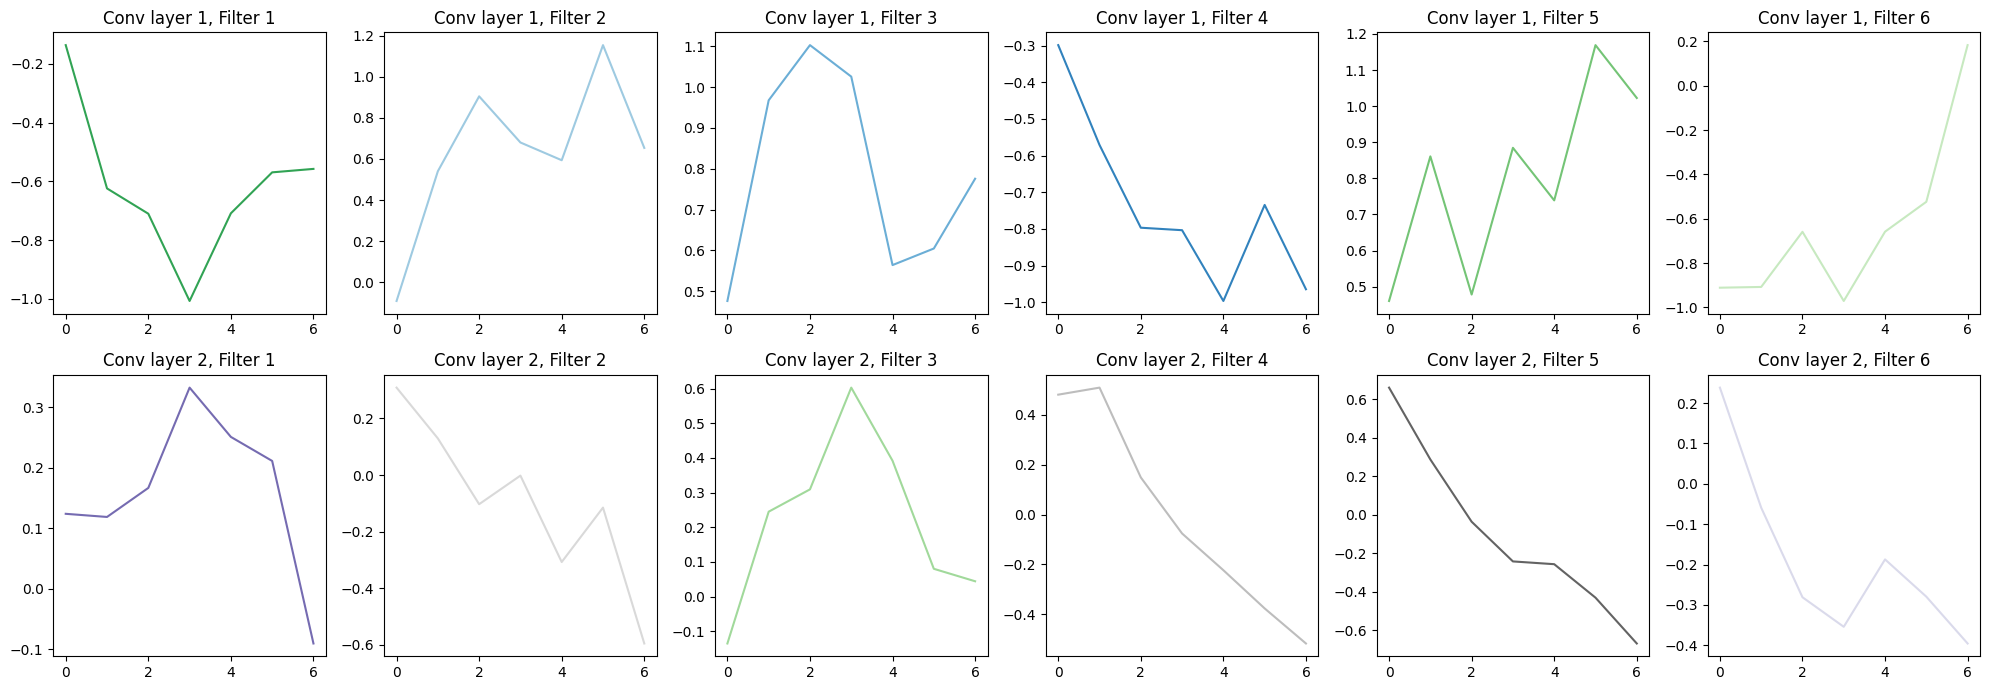

In [31]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

cnn_best = tf.keras.models.load_model("best_cnn.keras", compile=False)

#get conv weights of layer 1 (if you replace 0 by 1, you get the bias)
conv1_weights = cnn_best.layers[1].get_weights()[0]

#get conv weights of layer 2 (in TimeCNN, it corresponds to layer 3)
conv2_weights = cnn_best.layers[3].get_weights()[0]

fig,ax = plt.subplots(2,6,figsize=(20,7))

cmap = plt.get_cmap('tab20c')
values = np.linspace(0, 1, 18)
np.random.shuffle(values)

for i in range(6):
  ax[0,i].plot(conv1_weights[:,0,i],color=cmap(values[i]))
  ax[0,i].set_title('Conv layer 1, Filter ' + str(i+1))
  ax[1,i].plot(conv2_weights[:,0,i],color=cmap(values[6+i]))
  ax[1,i].set_title('Conv layer 2, Filter ' + str(i+1))
plt.tight_layout()
plt.show()

os.remove("best_cnn.keras")

In [44]:
from aeon.regression.deep_learning import CNNRegressor
from sklearn.metrics import mean_squared_error

cnn_rgs = CNNRegressor(n_epochs=100)
cnn_rgs.fit(X_train_r, y_train_r)
cnn_rgs_preds = cnn_rgs.predict(X_test_r)
print(mean_squared_error(y_test_r, cnn_rgs_preds))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
0.0021204361488597594


(<Figure size 600x600 with 1 Axes>,
 <Axes: title={'center': 'TimeCNN Predictions'}, xlabel='Actual values', ylabel='Predicted values'>)

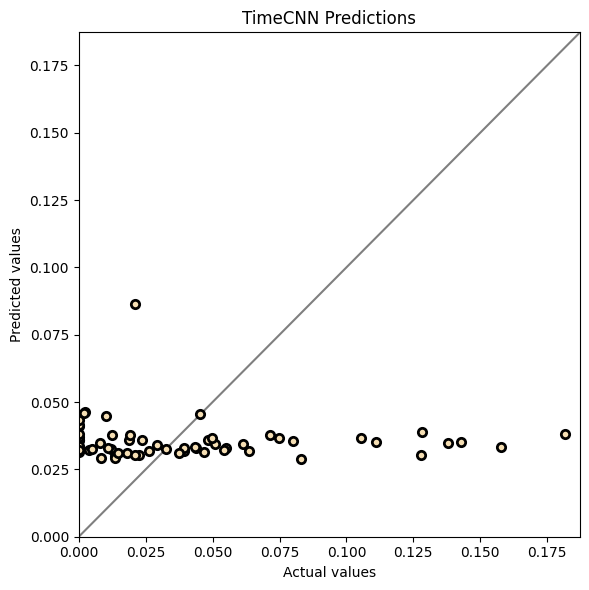

In [45]:
from aeon.visualisation import plot_scatter_predictions

plot_scatter_predictions(y_test_r, cnn_rgs_preds, title="TimeCNN Predictions")

## Inception Based Models <a id="inception-models"></a>

__Warning:__ The following models are computationally expensive and may take a long time to train on some setups (especially with no GPU).

### InceptionTime <a id="inceptiontime"></a>

InceptionTime [[3]](#references) is an ensemble of multiple Inception models, a convolution based neural network that leverages over TimeCNN by applying different convolution layers in parallel with different characteristics as well as using residual connections to avoid the vanishing gradient issue.

<img src="./img/InceptionTime.png" alt="inctime"><i>

#### Using InceptionTime for Classification and Regression <a id='inceptiontime-usage'></a>

In [46]:
from aeon.classification.deep_learning import InceptionTimeClassifier
from sklearn.metrics import accuracy_score

inceptiontime_cls = InceptionTimeClassifier(n_epochs=100)
inceptiontime_cls.fit(X_train_c, y_train_c)
inceptiontime_cls_preds = inceptiontime_cls.predict(X_test_c)
print("InceptionTime: ",accuracy_score(y_test_c, inceptiontime_cls_preds))

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 327ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 300ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 327ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step
InceptionTime:  0.36


In [47]:
from aeon.regression.deep_learning import InceptionTimeRegressor
from sklearn.metrics import mean_squared_error

inceptiontime_rgs = InceptionTimeRegressor(n_epochs=100)
inceptiontime_rgs.fit(X_train_r, y_train_r)
inceptiontime_rgs_preds = inceptiontime_rgs.predict(X_test_r)
print("InceptionTime: ",mean_squared_error(y_test_r, inceptiontime_rgs_preds))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
InceptionTime:  0.0021279716740978368


(<Figure size 600x600 with 1 Axes>,
 <Axes: title={'center': 'InceptionTime Regressor Predictions'}, xlabel='Actual values', ylabel='Predicted values'>)

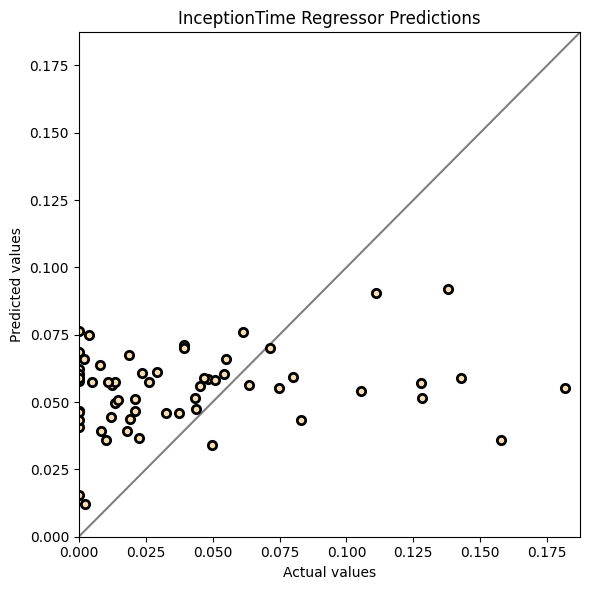

In [48]:
from aeon.visualisation import plot_scatter_predictions

plot_scatter_predictions(y_test_r, inceptiontime_rgs_preds, title="InceptionTime Regressor Predictions")

### Hybrid InceptionTime <a id="hinceptiontime"></a>

H-InceptionTime [[4]](#references) leverages over the InceptionTime model by adding some hand-crafted convolution filters at the beginning of the model. Such feature engineering technique helps the model generalize better to unseen cases.

<img src="./img/hcf.png" style="width: 50%; height: auto; display: block; margin-left: auto; margin-right: auto;" alt="hcf"><i>

#### Using Hybrid InceptionTime for Classification and Regression <a id='hinceptiontime-usage'></a>

In [49]:
from aeon.classification.deep_learning import InceptionTimeClassifier
from sklearn.metrics import accuracy_score

h_inceptiontime_cls = InceptionTimeClassifier(n_epochs=100, use_custom_filters=True)
h_inceptiontime_cls.fit(X_train_c, y_train_c)
h_inceptiontime_cls_preds = h_inceptiontime_cls.predict(X_test_c)
print("H-InceptionTime: ",accuracy_score(y_test_c, h_inceptiontime_cls_preds))

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 261ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 259ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 265ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 266ms/step
H-InceptionTime:  0.54


In [50]:
from aeon.regression.deep_learning import InceptionTimeRegressor
from sklearn.metrics import mean_squared_error

h_inceptiontime_rgs = InceptionTimeRegressor(n_epochs=100, use_custom_filters=True)
h_inceptiontime_rgs.fit(X_train_r, y_train_r)
h_inceptiontime_rgs_preds = h_inceptiontime_rgs.predict(X_test_r)
print("H-InceptionTime: ",mean_squared_error(y_test_r, h_inceptiontime_rgs_preds))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
H-InceptionTime:  0.0024461118478192375


(<Figure size 600x600 with 1 Axes>,
 <Axes: title={'center': 'H-InceptionTime Regressor Predictions'}, xlabel='Actual values', ylabel='Predicted values'>)

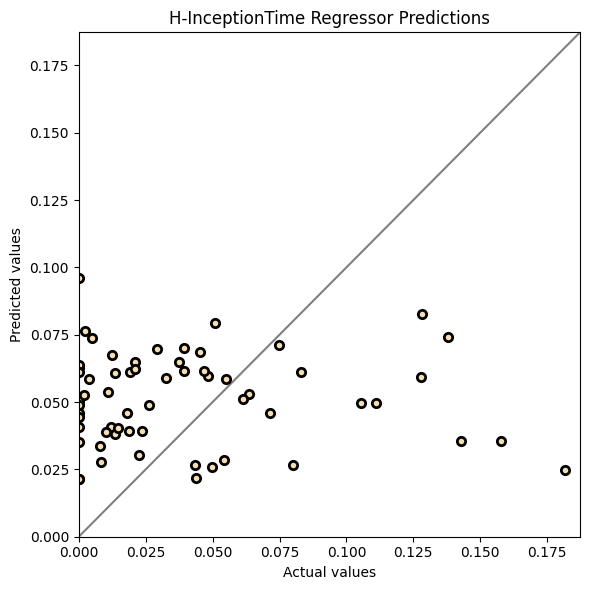

In [51]:
from aeon.visualisation import plot_scatter_predictions

plot_scatter_predictions(y_test_r, h_inceptiontime_rgs_preds, title="H-InceptionTime Regressor Predictions")

### LITETime <a id="litetime"></a>

LITETime [[9]](#references) is currently the smallest deep learning model that achieves state-of-the-art performance on TSC. It is based on the Inception architecture but with way less parameters to train while utilizing as well the hand-crafted convolution filters in the first layer.

<img src="./img/LITE.png" alt="lite"><i>

#### Using LITETime for Classification and Regression <a id='litetime-usage'></a>

In [52]:
from aeon.classification.deep_learning import LITETimeClassifier
from sklearn.metrics import accuracy_score

litetime_cls = LITETimeClassifier(n_epochs=100)
litetime_cls.fit(X_train_c, y_train_c)
litetime_cls_preds = litetime_cls.predict(X_test_c)
print("LITETime: ",accuracy_score(y_test_c, litetime_cls_preds))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
LITETime:  0.36


In [53]:
from aeon.regression.deep_learning import LITETimeRegressor
from sklearn.metrics import mean_squared_error

litetime_rgs = LITETimeRegressor(n_epochs=100)
litetime_rgs.fit(X_train_r, y_train_r)
litetime_rgs_preds = litetime_rgs.predict(X_test_r)
print("LITETime: ",mean_squared_error(y_test_r, litetime_rgs_preds))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
LITETime:  0.002171717259618397


(<Figure size 600x600 with 1 Axes>,
 <Axes: title={'center': 'LITETime Regressor Predictions'}, xlabel='Actual values', ylabel='Predicted values'>)

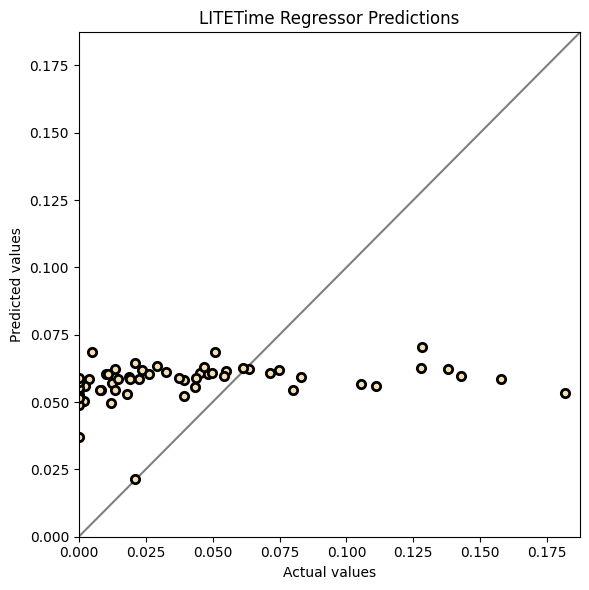

In [54]:
from aeon.visualisation import plot_scatter_predictions

plot_scatter_predictions(y_test_r, litetime_rgs_preds, title="LITETime Regressor Predictions")

## Performance on the UCR univariate classification datasets <a id='evaluation'></a>

Below we show the performance of the `MLP`, `InceptionTime` and `H-InceptionTime` deep learning models on the UCR TSC archive datasets [[4]](#references) using results from the TSC bake off in 2024 [[5]](#references).

In [55]:
from aeon.benchmarking import get_estimator_results_as_array
from aeon.datasets.tsc_datasets import univariate

names = ["CNN", "InceptionTime", "H-InceptionTime", "LITETime", "1NN-DTW"]
results, present_names = get_estimator_results_as_array(
    names, univariate, include_missing=False
)
results.shape

(112, 5)

(<Figure size 1000x600 with 1 Axes>, <Axes: >)

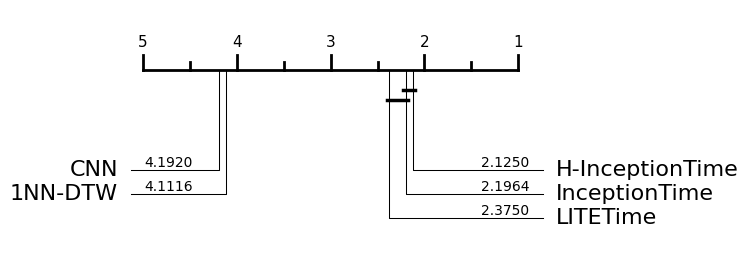

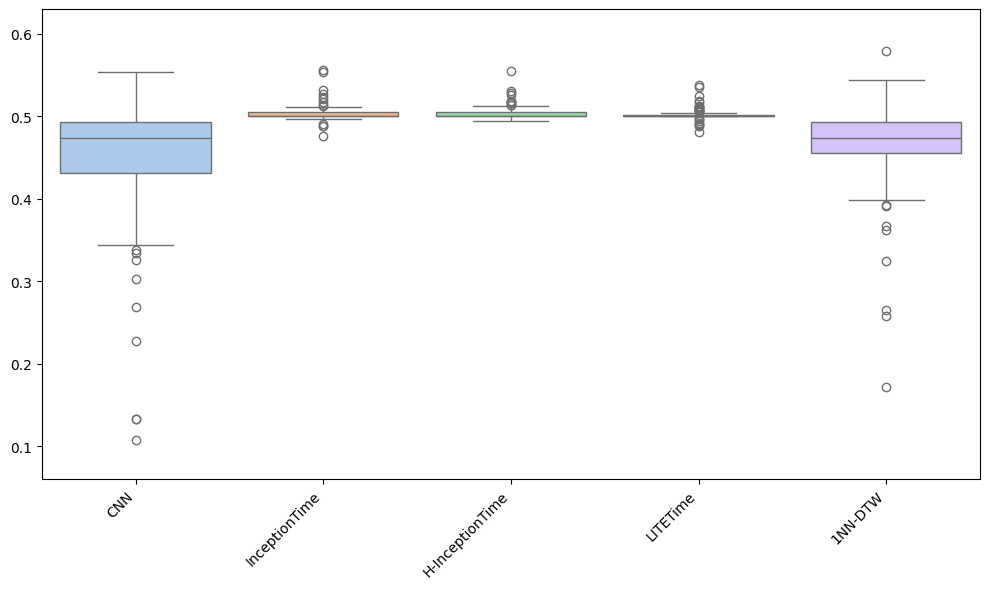

In [56]:
from aeon.visualisation import plot_critical_difference
from aeon.visualisation import plot_boxplot_median

plot_critical_difference(results, names)
plot_boxplot_median(results, names, plot_type="boxplot")

## Deep Learning for Time Series Clustering <a id='clustering'></a>



Deep Learning for TSCL [[7]](#references) has been seen to be very effective and outperforms distance and shape based methods over the UCR archive. The best approach to perform deep TSCL, following [[7]](#references) is using Auto-Encoder based models and perform the clustering in the learned representation space.

<img src="./img/auto-encoder.png" alt="ae"><i>

### Auto-Encoder Fully Convolutional Network (AEFCN) for Clustering <a id='aefcn'></a>

Using the original Fully Convolutional Network (FCN) made for classification, an Auto-Encoder (AE) architecture can be constructed using convolution transpose in the decoder network.

In [57]:
from aeon.clustering.deep_learning import AEFCNClusterer
from sklearn.metrics import adjusted_rand_score

ae_fcn = AEFCNClusterer(n_epochs=100)

ae_fcn.fit(X_train_c)
ae_fcn_preds = ae_fcn.predict(X_test_c)
print("AEFCN: ",adjusted_rand_score(y_test_c, ae_fcn_preds))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
AEFCN:  0.21253631471162546


### Auto-Encoder ResNet (AEResNet) for Clustering <a id='aeresnt'></a>

The best performing AE based deep clusterer following [[7]](#references) is using ResNet architecture.

In [58]:
from aeon.clustering.deep_learning import AEResNetClusterer
from sklearn.metrics import adjusted_rand_score

ae_resnet = AEResNetClusterer(n_epochs=100)

ae_resnet.fit(X_train_c)
ae_resnet_preds = ae_resnet.predict(X_test_c)
print("AEFCN: ",adjusted_rand_score(y_test_c, ae_resnet_preds))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
AEFCN:  0.23352325852768085


## References <a id='references'></a>

[1] Ismail Fawaz, Hassan, et al. "Deep learning for time series classification: a review." Data mining and knowledge discovery 33.4 (2019): 917-963.

[2] Wang, Zhiguang et al. "Time series classification from scratch with deep neural networks: A strong baseline." 2017 International joint conference on neural networks (IJCNN). IEEE, 2017.

[3] Ismail Fawaz, Hassan, et al. "Inceptiontime: Finding alexnet for time series classification." Data Mining and Knowledge Discovery 34.6 (2020): 1936-1962.

[4] Ismail-Fawaz, Ali, et al. "Deep Learning For Time Series Classification Using New Hand-Crafted Convolution Filters." International Conference on Big Data. IEEE, (2022).

[5] Middlehurst, Matthew, Patrick Schäfer, and Anthony Bagnall. "Bake off redux: a review and experimental evaluation of recent time series classification algorithms." Data Mining and Knowledge Discovery (2024): 1-74.

[6] Guijo-Rubio, David, et al. "Unsupervised Feature Based Algorithms for Time Series Extrinsic Regression." arXiv preprint arXiv:2305.01429 (2023).

[7] Lafabregue, Baptiste, et al. "End-to-end deep representation learning for time series clustering: a comparative study." Data Mining and Knowledge Discovery 36.1 (2022): 29-81.

[8] Zhao et al. Convolutional neural networks for time series classification. Journal of Systems Engineering and Electronics 28.1 (2017)

[9] Ismail-Fawaz, Ali, et al. "Lite: Light inception with boosting techniques for time series classification." 2023 IEEE 10th International Conference on Data Science and Advanced Analytics (DSAA). IEEE, 2023.

[Return to Table of Contents](#toc)